In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [13]:
df=pd.read_excel('Dataset_FINAL.xlsx', delimiter=';',header = 0)
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (1096, 75)


Date  102RIN1  110D  110I    111I  111N    112D    112I  113D  113I  \
0 2016-01-01      nan    20    10 21.0000    15 20.0000 21.0000    20    22   
1 2016-01-02      nan    24    11 21.0000    17 18.0000 21.0000    20    24   
2 2016-01-03      nan    22    11 19.0000    16 21.0000 21.0000    18    23   
3 2016-01-04      nan    24    11 18.0000    14 20.0000 21.0000    20    21   
4 2016-01-05      nan    23    10 18.0000    16 20.0000 23.0000    18    23   

   ...    301R    307A    307B  308A  309A   310D  310M  UGINTRAS  UPEDTRAS  \
0  ... 16.0000 10.0000  8.0000     2    25 1.0000    19       nan       nan   
1  ... 16.0000 10.0000  7.0000    13    22    nan    16       nan       nan   
2  ... 14.0000  7.0000 16.0000    18    17 2.0000    17       nan       nan   
3  ... 14.0000  9.0000  8.0000     9    18 2.0000    13       nan       nan   
4  ... 15.0000  8.0000  5.0000     6    16 2.0000    17       nan       nan   

   UVIU  
0     8  
1     7  
2     7  
3     6  
4     8  

[5 rows x 75 columns]

Approx 1.2% of value in Estancias column are missing, it is not a big deal, I decided to remove them.

In [14]:
df.columns

Index(['Date', '102RIN1', '110D', '110I', '111I', '111N', '112D', '112I',
       '113D', '113I', '114D', '114I', '115D', '115I', '11AS', '11AV', '11CT',
       '11DD', '11UA', '12ID', '12ND', '12NI', '12RE', '13CV', '13IC', '13MX',
       '13RE', '14CD', '14CI', '14CT', '14DI', '14TX', '15BA', '15BB', '15CA',
       '15CE', '16DD', '16DI', '16ID', '16II', '17CC', '18II', '18OR', '19UD',
       '19UI', '1ABP', '1BHD', '1BJH', '1BJT', '1PRE', '1RBJ', '1RSS', '1URG',
       '200D', '200E', '200R', '203A', '203B', '204A', '205A', '300I', '300T',
       '300U', '301A', '301D', '301R', '307A', '307B', '308A', '309A', '310D',
       '310M', 'UGINTRAS', 'UPEDTRAS', 'UVIU'],
      dtype='object')

In [15]:
df.columns
df['date_time'] = df['Date']
df['date_time']

0      2016-01-01
1      2016-01-02
2      2016-01-03
3      2016-01-04
4      2016-01-05
          ...    
1091   2018-12-27
1092   2018-12-28
1093   2018-12-29
1094   2018-12-30
1095   2018-12-31
Name: date_time, Length: 1096, dtype: datetime64[ns]

In [16]:
df['Total'] = df.sum(axis=1)
df['Estancias'] = df.Total

df['Estancias'] = pd.to_numeric(df['Estancias'], errors='coerce')
df = df.dropna(subset=['Estancias'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Estancias', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print(df.shape)
print(df.date_time.min())
print(df.date_time.max())
df.tail(5)

(1096, 7)
2016-01-01 00:00:00
2018-12-31 00:00:00


date_time  Estancias  year  quarter  month  day  weekday
1091 2018-12-27   841.0000  2018        4     12   27        1
1092 2018-12-28   767.0000  2018        4     12   28        1
1093 2018-12-29   786.0000  2018        4     12   29        0
1094 2018-12-30   800.0000  2018        4     12   30        0
1095 2018-12-31   815.0000  2018        4     12   31        1

In [17]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (1096, 7)
The time series starts from:  2016-01-01 00:00:00
The time series ends on:  2018-12-31 00:00:00


### Statistical Normality Test

There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K^2 Test.

In the SciPy implementation of the test, we will interpret the p value as follows.

* p <= alpha: reject H0, not normal.
* p > alpha: fail to reject H0, normal.

In [18]:
df['Total'] = df.sum(axis=1)

In [19]:
stat, p = stats.normaltest(df.Total)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=58.727, p=0.000
Data does not look Gaussian (reject H0)


We can also calculate kurtosis and skewness, to determine if the data distribution departs from the normal distribution.

In [20]:
df.Estancias = df.Total

In [21]:
# print(df.Estancias.describe())
ax =sns.distplot(df.Estancias);
ax.set_title('Distribucion de las Estancias')
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Estancias)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Estancias)))

Kurtosis of normal distribution: -0.4615809030660416
Skewness of normal distribution: -0.5074041356556096


KURTOSIS: describes heaviness of the tails of a distribution

Normal Distribution has a kurtosis of close to 0.  If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero. 

SKEWNESS:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

### First Time series plot

In [100]:
df1=df.loc[:,['date_time','Estancias']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Estancias')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Seies Temporales de las Estancias')
sns.despine(top=True)
plt.show();

Apparently, this plot is not a good idea. Don't do this.

In [101]:
df2=df1[(df1.index>='2016-07-01') & (df1.index<'2017-7-16')]
df2.plot(figsize=(12,5));
plt.ylabel('Estancias')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

### Box plot of yearly vs. quarterly Estancias

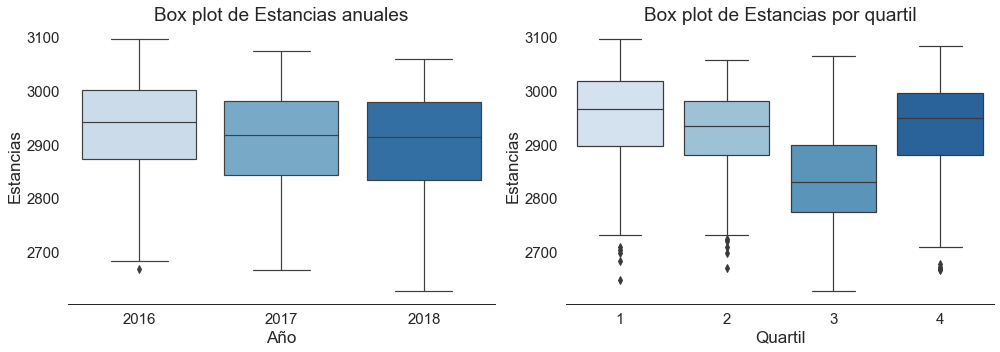

In [102]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=6.9)

b =sns.boxplot(x="year", y="Estancias", data=df,palette="Blues")
b.tick_params(labelsize=15)
plt.ylabel('Estancias',fontsize=17)

plt.xlabel('Año', fontsize=17)
plt.title('Box plot de Estancias anuales',fontsize=19)
sns.despine(left=True)
plt.tight_layout() 

plt.subplot(1,2,2)
b=sns.boxplot(x="quarter", y="Estancias", data=df,palette="Blues")

b.tick_params(labelsize=15)
plt.ylabel('Estancias',fontsize=17)
plt.xlabel('Quartil',fontsize=17)
plt.title('Box plot de Estancias por quartil',fontsize=19)
sns.despine(left=True)
plt.tight_layout();

### Estancias Distribution

count      mean     std       min       25%       50%       75%  \
Estancias 1096.0000 2911.1715 95.1190 2627.0000 2847.0000 2921.0000 2987.0000   
year      1096.0000 2016.9991  0.8171 2016.0000 2016.0000 2017.0000 2018.0000   
quarter   1096.0000    2.5082  1.1177    1.0000    2.0000    3.0000    4.0000   
month     1096.0000    6.5219  3.4506    1.0000    4.0000    7.0000   10.0000   
day       1096.0000   15.7327  8.8054    1.0000    8.0000   16.0000   23.0000   
weekday   1096.0000    0.7135  0.4523    0.0000    0.0000    1.0000    1.0000   
Total     1096.0000 2911.1715 95.1190 2627.0000 2847.0000 2921.0000 2987.0000   

                max  
Estancias 3096.0000  
year      2018.0000  
quarter      4.0000  
month       12.0000  
day         31.0000  
weekday      1.0000  
Total     3096.0000

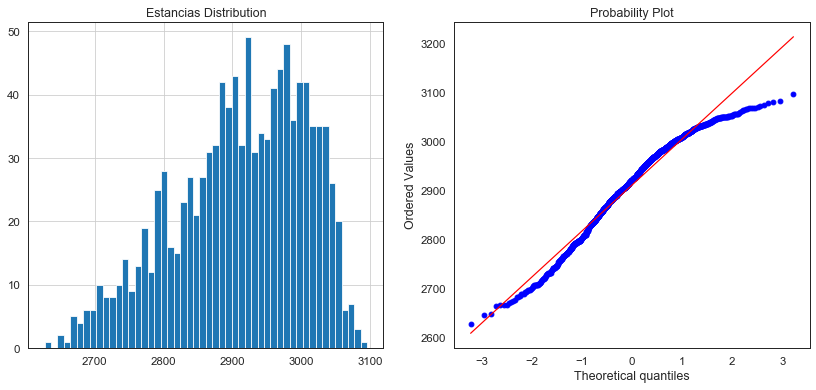

In [103]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Estancias'].hist(bins=50)
plt.title('Estancias Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Estancias'], plot=plt);
df.describe().T

Normal probability plot also shows the data set is far from normally distributed.

### Average Estancias resampled over day, week, month, quarter and year.

In [111]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Estancias'].resample('D').mean(),linewidth=1)
ax1.set_title('Media de estancias por dia',fontsize=17)
ax1.tick_params(axis='both', which='major',labelsize=15)

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Estancias'].resample('W').mean(),linewidth=1)
ax2.set_title('Media de estancias por semana',fontsize=17)
ax2.tick_params(axis='both', which='major',labelsize=15)

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Estancias'].resample('M').mean(),linewidth=1)
ax3.set_title('Media de estancias por mes',fontsize=17)
ax3.tick_params(axis='both', which='major',labelsize=15)

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Estancias'].resample('Q').mean(),linewidth=1)
ax4.set_title('Media de estancias por quartil',fontsize=17)
ax4.tick_params(axis='both', which='major',labelsize=15)

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Estancias'].resample('A').mean(),linewidth=1)
ax5.set_title('Media de estancias por Año',fontsize=17)
ax5.tick_params(axis='both', which='major',labelsize=15);

In general, our time series does not have a general upward or downward trend. The highest estancias was prior to 20017, it decreased significantly in one year until early 20018, and has been steady since then.

### Plot mean Estancias grouped by year, quarter, month and day.

In [115]:
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
df.groupby('year').Estancias.agg('mean').plot()
plt.xlabel('',fontsize=19)
plt.title('Media de estancias por Año',fontsize=19)

plt.subplot(2,2,2)
df.groupby('quarter').Estancias.agg('mean').plot()
plt.xlabel('',fontsize=19)
plt.title('Media de estancias por Quartil',fontsize=19)

plt.subplot(2,2,3)
df.groupby('month').Estancias.agg('mean').plot()
plt.xlabel('',fontsize=19)
plt.title('Media de estancias por Mes',fontsize=19)

plt.subplot(2,2,4)
df.groupby('day').Estancias.agg('mean').plot()
plt.xlabel('',fontsize=19)
plt.title('Media de estancias por Día',fontsize=19);

The above plots confirmed our previous discoveries. By year, the highest estancias number was prior to 2007, and it has been consistent since then. By quarter, the lowest estancias number was in the 3rd quarter. By month, the lowest estancias numbern was in July and August.

### Estancias by Years

For 2019, we only have data for December, so remove 2006.

In [118]:
pd.pivot_table(df.loc[df['year'] != 2006], values = "Estancias", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

### Estancias consumption in Weekdays vs. Weekends

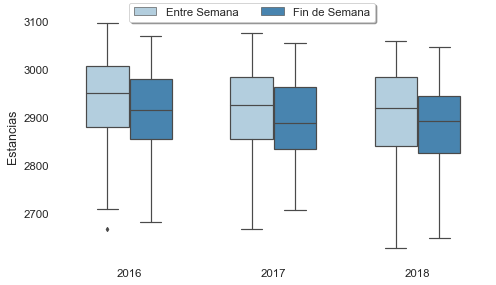

In [126]:
dic={0:'Fin de Semana',1:'Entre Semana'}
df['Day'] = df.weekday.map(dic)


a=plt.figure(figsize=(7,4)) 
plt1=sns.boxplot('year','Estancias',hue='Day',width=0.6,fliersize=3,
                    data=df,palette="Blues")                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('',fontsize=19)
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

The median Estancias in weekdays seems to be lower than the weekends prior to 2010.

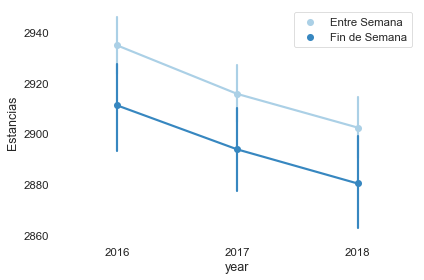

In [129]:
plt1=sns.factorplot('year','Estancias',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False,palette="Blues")                                                                                                                                                                                                                                                                                                                                             
#plt.title('Factor de estancias entre semana y el fin de semana')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

Both weekdays and weekends have the similar trends over year.

In principle we do not need to check for stationarity nor correct for it when we are using an LSTM. However, if the data is stationary, it will help with better performance and make it easier for the neural network to learn.

### Dickey-Fuller Test to Ceck Stationarity

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.

### Dickey-Fuller test

Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [119]:
#df2=df1.resample('D', how=np.mean)
df2 = df1.resample('D').agg(np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=10).mean()
    rolstd = timeseries.rolling(window=10).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

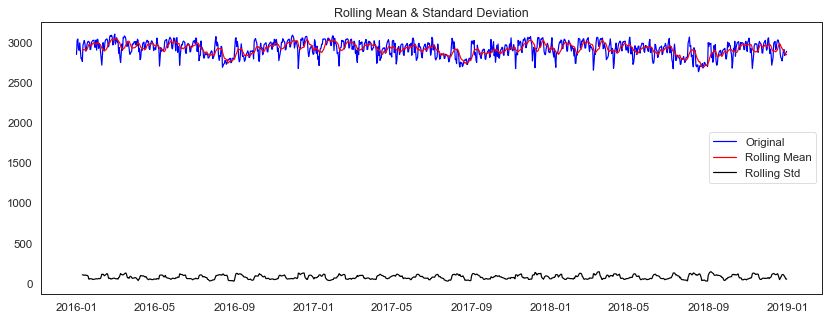

<Results of Dickey-Fuller Test>
Test Statistic                  -4.8652
p-value                          0.0000
#Lags Used                      22.0000
Number of Observations Used   1073.0000
Critical Value (1%)             -3.4365
Critical Value (5%)             -2.8642
Critical Value (10%)            -2.5682
dtype: float64


In [123]:
test_stationarity(df2.Estancias.dropna())

From the above results, we will reject the null hypothesis H0, the data does not have a unit root and is stationary.

## LSTM


Create dataset, normalize the dataset, split into training and test sets, convert an array of values into a dataset matrix

In [132]:
dataset = df.Estancias.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [133]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [134]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [135]:
X_train.shape

(845, 30)

In [136]:
Y_train.shape

(845,)

In [137]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Model Architecture

In [138]:
X_train.shape

(845, 1, 30)

In [139]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 845 samples, validate on 189 samples
Epoch 1/20
845/845 [==============================] - 0s 517us/step - loss: 0.1351 - val_loss: 0.0682
Epoch 2/20
845/845 [==============================] - 0s 50us/step - loss: 0.0588 - val_loss: 0.0456
Epoch 3/20
845/845 [==============================] - 0s 50us/step - loss: 0.0399 - val_loss: 0.0443
Epoch 4/20
845/845 [==============================] - 0s 47us/step - loss: 0.0354 - val_loss: 0.0437
Epoch 5/20
845/845 [==============================] - 0s 47us/step - loss: 0.0351 - val_loss: 0.0412
Epoch 6/20
845/845 [==============================] - 0s 48us/step - loss: 0.0336 - val_loss: 0.0401
Epoch 7/20
845/845 [==============================] - 0s 47us/step - loss: 0.0325 - val_loss: 0.0384
Epoch 8/20
845/845 [==============================] - 0s 48us/step - loss: 0.0308 - val_loss: 0.0371
Epoch 9/20
845/845 [==============================] - 0s 48us/step - loss: 0.0308 - val_loss: 0.0355
Epoch 10/20
845/845 [=======================

In [88]:
data = df['Estancias']
data_estancias =  df[['Estancias']]

In [140]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 54.54004699104117
Train Root Mean Squared Error: 67.0937671481651
Test Mean Absolute Error: 63.14882412606542
Test Root Mean Squared Error: 75.52014538940774


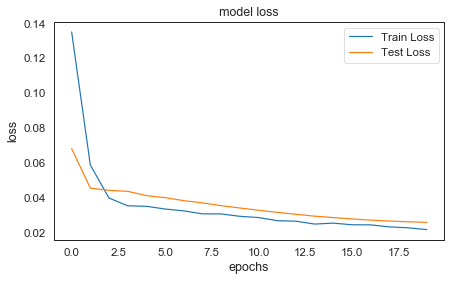

In [153]:
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

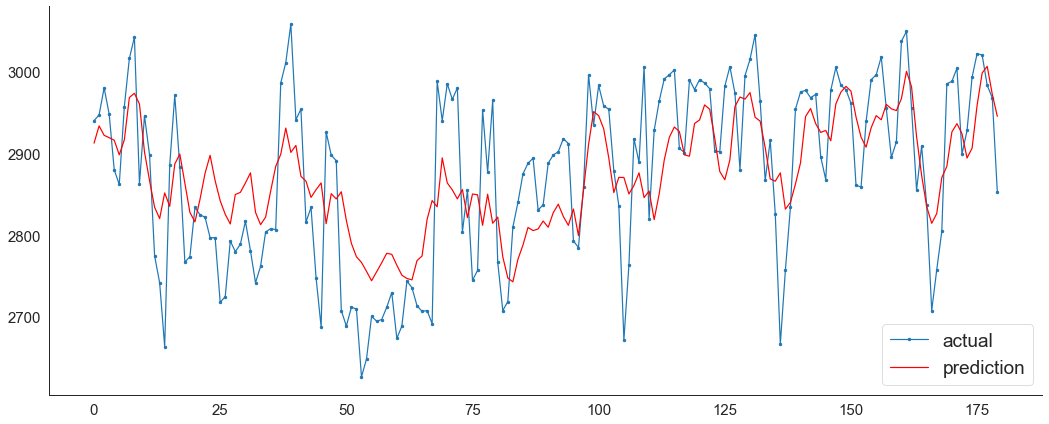

In [150]:
aa=[x for x in range(180)]
plt.figure(figsize=(15,6))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tick_params(labelsize=15) #remove ticks
plt.tight_layout()
b = sns.despine(top=True)


plt.subplots_adjust(left=0.07)
#plt.ylabel('Estancias', size=19,fontsize=17)
#plt.xlabel('Time step', size=19,fontsize=17)
plt.legend(fontsize=19)
plt.show();